In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
def getTCGA(disease):
    path = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP/TCGA/TCGA_{}_counts.tsv.gz"
    files = [path.format(d) for d in disease]
    return files

In [4]:
def readGCP(files, biotype='protein_coding', mean=True):
    """
    Paths to count matrices.
    """
    data_dict = {}
    for f in files:
        key = os.path.basename(f).split("_")[1]
        data = pd.read_csv(f, sep='\t', index_col=0)
        # transcript metadata
        meta = pd.DataFrame([row[:-1] for row in data.index.str.split("|")],
                            columns=['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'GENE', 'BP', 'BIOTYPE'])
        meta = pd.MultiIndex.from_frame(meta)
        data.index = meta
        # subset transcripts
        data = data.xs(key=biotype, level='BIOTYPE')
        data = data.droplevel(['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'BP'])
        # average gene expression of splice variants
        data = data.T
        if mean:
            data = data.groupby(by=data.columns, axis=1).mean()
        data_dict[key] = data
    return data_dict

In [5]:
def renameTCGA(data_dict, mapper):
    for key in data_dict.keys():
        data_dict[key] = data_dict[key].rename(mapper)
    return data_dict

In [6]:
def uq_norm(df, q=0.75):
    """
    Upper quartile normalization of GEX for samples.
    """
    quantiles = df.quantile(q=q, axis=1)
    norm = df.divide(quantiles, axis=0)
    return norm

In [7]:
base = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP"
disease = ['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM']

tcga_files = getTCGA(disease)
tcga_meta = pd.read_csv(os.path.join(base, "TCGA/TCGA_GDC_ID_MAP.tsv"), sep="\t")
tcga_raw = readGCP(tcga_files, mean=True)

In [8]:
# rename samples to reflect canonical IDs
tcga_raw = renameTCGA(tcga_raw, mapper=dict(zip(tcga_meta['CGHubAnalysisID'], tcga_meta['Sample ID'])))

In [9]:
# combine samples
tcga_raw = pd.concat(tcga_raw.values())

## Normalization

In [10]:
# Upper quartile normalization
tcga_tmp = uq_norm(tcga_raw)

In [11]:
# log norm
tcga = tcga_raw.transform(np.log1p)

In [12]:
# downsample
#tcga = tcga_raw.sample(n=40000, axis=1)

In [13]:
#tcga = tcga_raw

# Model

### Experimental Setup

In [14]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Disease':['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [15]:
class Experiment():
    """
    Defines an experimental class hierarchy object.
    """
    def __init__(self, meta_data, hierarchy, cases, min_samples):
        self.hierarchy = hierarchy
        self.meta_data = self.categorize(meta_data, self.hierarchy, min_samples)
        self.cases = self.meta_data[cases].unique()
        self.labels = self.meta_data['meta'].cat.codes.values.astype('int')
        self.labels_dict = {key:val for key,val in enumerate(self.meta_data['meta'].cat.categories.values)}
        
    def categorize(self, meta_data, hierarchy, min_samples):
        assert isinstance(hierarchy, OrderedDict), "Argument of wrong type."
        # downsample data
        for key,val in hierarchy.items():
            meta_data = meta_data[meta_data[key].isin(val)]
        # unique meta classes
        meta_data['meta'] = meta_data[list(hierarchy.keys())].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
        # filter meta classes
        counts = meta_data['meta'].value_counts()
        keep = counts[counts > min_samples].index
        meta_data = meta_data[meta_data['meta'].isin(keep)]
        # generate class categories
        meta_data['meta'] = meta_data['meta'].astype('category')
        return meta_data
    
    def holdout(self, holdout):
        self.holdout = holdout
        self.holdout_samples = self.meta_data[self.meta_data['meta'].isin(holdout)]
        self.meta_data = self.meta_data[~self.meta_data['meta'].isin(holdout)]

In [16]:
from dutils import train_test_split_case
exp = Experiment(meta_data=tcga_meta,
                 hierarchy=hierarchy,
                 cases='Case ID',
                 min_samples=20)
exp.holdout(holdout=['SKCM:Metastatic'])

In [17]:
exp.meta_data['meta'].value_counts()
exp.holdout_samples['meta'].value_counts()

BRCA:Primary Tumor          1119
KIRC:Primary Tumor           542
LUAD:Primary Tumor           536
THCA:Primary Tumor           502
PRAD:Primary Tumor           501
BRCA:Solid Tissue Normal     114
SKCM:Primary Tumor           103
KIRC:Solid Tissue Normal      72
LUAD:Solid Tissue Normal      59
THCA:Solid Tissue Normal      58
PRAD:Solid Tissue Normal      52
SKCM:Metastatic                0
Name: meta, dtype: int64

SKCM:Metastatic             367
THCA:Solid Tissue Normal      0
THCA:Primary Tumor            0
SKCM:Primary Tumor            0
PRAD:Solid Tissue Normal      0
PRAD:Primary Tumor            0
LUAD:Solid Tissue Normal      0
LUAD:Primary Tumor            0
KIRC:Solid Tissue Normal      0
KIRC:Primary Tumor            0
BRCA:Solid Tissue Normal      0
BRCA:Primary Tumor            0
Name: meta, dtype: int64

In [18]:
# Define Train / Test sample split
target = 'meta'

train, test = train_test_split_case(exp.meta_data, cases='Case ID')
# stratification is not quite perfect but close
# in order to preserve matched samples for each case together
# in train or test set
case_counts = exp.meta_data[target].value_counts()
train[target].value_counts()[case_counts.index.to_numpy()] / case_counts
test[target].value_counts()[case_counts.index.to_numpy()] / case_counts

BRCA:Primary Tumor          0.806971
KIRC:Primary Tumor          0.791513
LUAD:Primary Tumor          0.798507
THCA:Primary Tumor          0.788845
PRAD:Primary Tumor          0.802395
BRCA:Solid Tissue Normal    0.789474
SKCM:Primary Tumor          0.854369
KIRC:Solid Tissue Normal    0.763889
LUAD:Solid Tissue Normal    0.813559
THCA:Solid Tissue Normal    0.862069
PRAD:Solid Tissue Normal    0.807692
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

BRCA:Primary Tumor          0.193029
KIRC:Primary Tumor          0.208487
LUAD:Primary Tumor          0.201493
THCA:Primary Tumor          0.211155
PRAD:Primary Tumor          0.197605
BRCA:Solid Tissue Normal    0.210526
SKCM:Primary Tumor          0.145631
KIRC:Solid Tissue Normal    0.236111
LUAD:Solid Tissue Normal    0.186441
THCA:Solid Tissue Normal    0.137931
PRAD:Solid Tissue Normal    0.192308
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

In [19]:
# sort so as to sync raw data downsample and labels **FIX**
train = train.sort_values(by='Sample ID')
test = test.sort_values(by='Sample ID')

In [20]:
# split data
train_data = tcga[tcga.index.isin(train['Sample ID'])].astype(np.float32).sort_index()
test_data = tcga[tcga.index.isin(test['Sample ID'])].astype(np.float32).sort_index()

In [21]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_data = pd.DataFrame(scaler.fit_transform(train_data),
#                                   index=train_data.index,
#                                   columns=train_data.columns)
# test_data = pd.DataFrame(scaler.transform(test_data),
#                                  index=test_data.index,
#                                  columns=test_data.columns)

In [22]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

Cuda is available: True


In [23]:
import torch
from torch.utils.data import Dataset

class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, meta_data, data, train=False):
        assert np.array_equal(meta_data['Sample ID'], data.index)
        self.train = train
        self.labels = meta_data['meta'].cat.codes.values.astype('int')

        if self.train:
            self.train_labels = self.labels
            self.train_data = torch.from_numpy(data.values).float()
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.labels
            self.test_data = torch.from_numpy(data.values).float()
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
        
        return (img1, img2), target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

# Siamese Network

In [24]:
siamese_train_dataset = SiameseDataset(meta_data=train,
                                       data=train_data,
                                       train=True)
siamese_test_dataset = SiameseDataset(meta_data=test,
                                      data=test_data,
                                      train=False)

In [25]:
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss, TripletLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.train_data.shape
embedding_net = EmbeddingNet(n_features, 2)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19594, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [26]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2931 (0%)]	Loss: 0.309164
Train: [736/2931 (25%)]	Loss: 0.195090
Train: [1472/2931 (50%)]	Loss: 0.265973
Train: [2208/2931 (75%)]	Loss: 0.085654
Epoch: 1/10. Train set: Average loss: 0.1458
Epoch: 1/10. Validation set: Average loss: 0.0344
Train: [0/2931 (0%)]	Loss: 0.052504
Train: [736/2931 (25%)]	Loss: 0.026158
Train: [1472/2931 (50%)]	Loss: 0.027146
Train: [2208/2931 (75%)]	Loss: 0.035620
Epoch: 2/10. Train set: Average loss: 0.0294
Epoch: 2/10. Validation set: Average loss: 0.0262
Train: [0/2931 (0%)]	Loss: 0.008632
Train: [736/2931 (25%)]	Loss: 0.020570
Train: [1472/2931 (50%)]	Loss: 0.024440
Train: [2208/2931 (75%)]	Loss: 0.019379
Epoch: 3/10. Train set: Average loss: 0.0197
Epoch: 3/10. Validation set: Average loss: 0.0224
Train: [0/2931 (0%)]	Loss: 0.022941
Train: [736/2931 (25%)]	Loss: 0.014639
Train: [1472/2931 (50%)]	Loss: 0.030734
Train: [2208/2931 (75%)]	Loss: 0.119764
Epoch: 4/10. Train set: Average loss: 0.0591
Epoch: 4/10. Validation set: Average loss: 0.0375


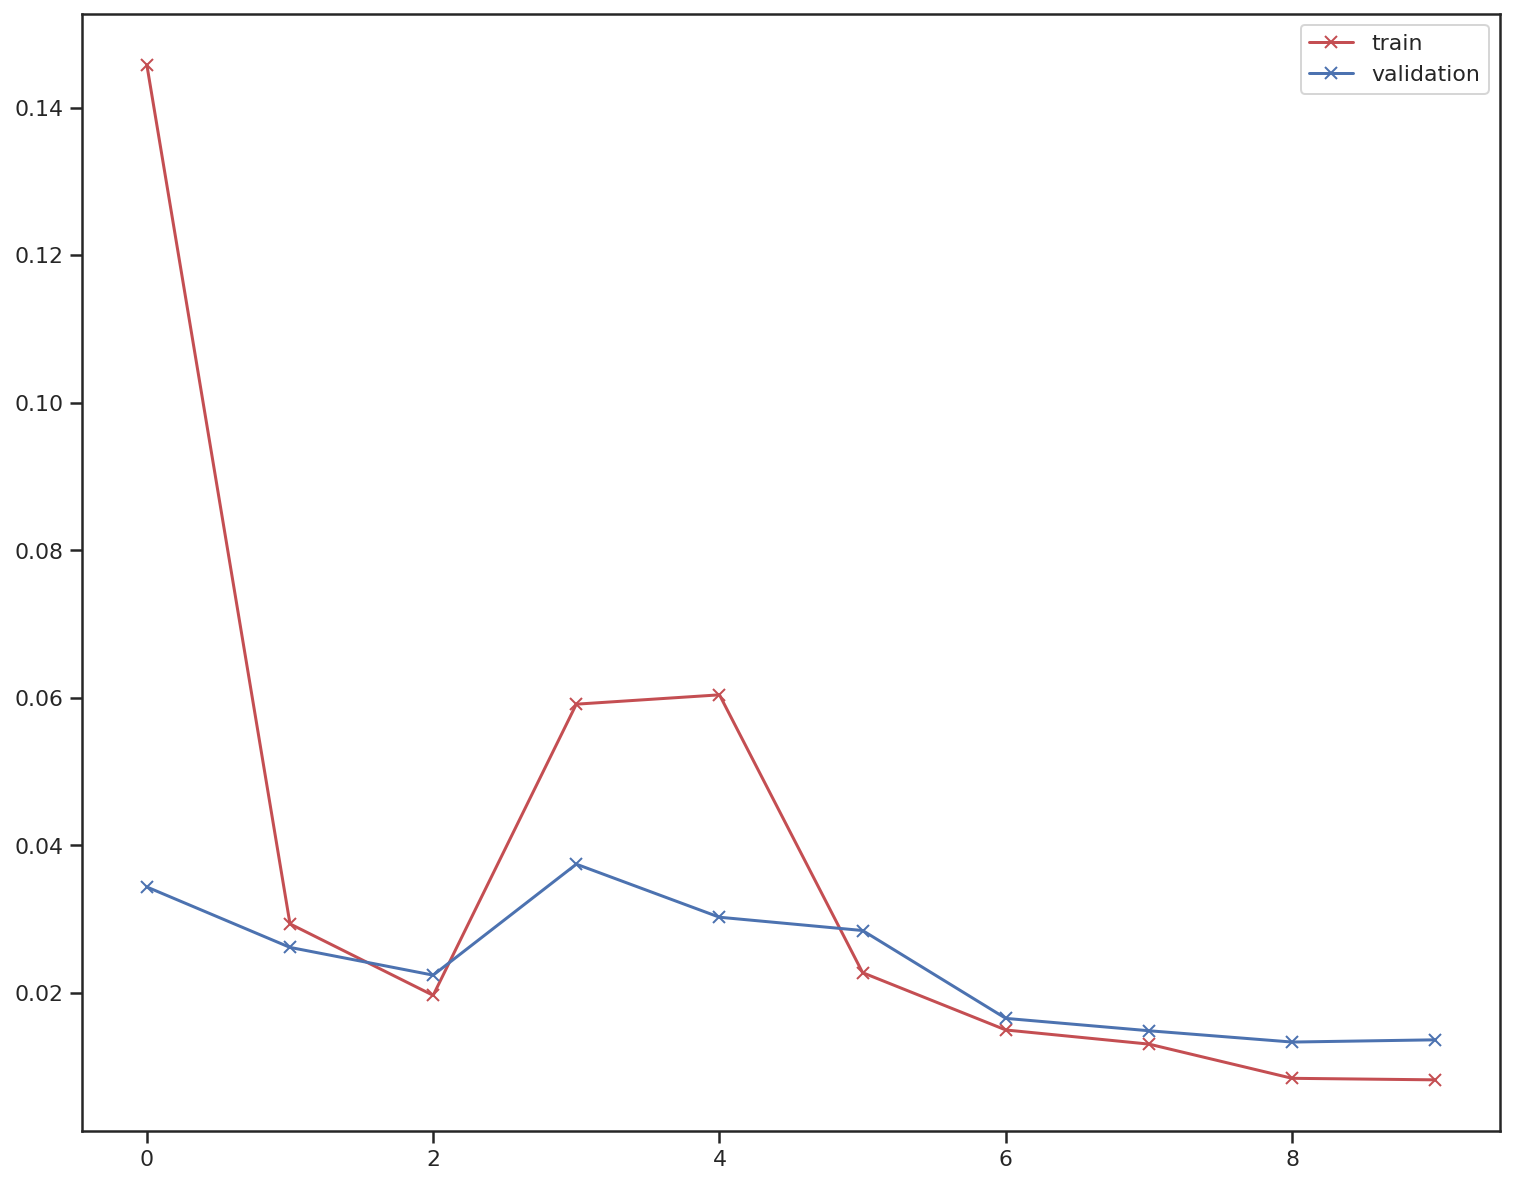

In [31]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

In [28]:
    
def extract_embeddings(samples, target, model):
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        assert len(samples) == len(target)
        embeddings = np.zeros((len(samples), 2))
        labels = np.zeros(len(target))
        k = 0
        if cuda:
            samples = samples.cuda()
        if isinstance(model, torch.nn.DataParallel):
            embeddings[k:k+len(samples)] = model.module.get_embedding(samples).data.cpu().numpy()
        else:
            embeddings[k:k+len(samples)] = model.get_embedding(samples).data.cpu().numpy()
        labels[k:k+len(samples)] = target
        k += len(samples)
    return embeddings, labels

Text(0.5, 1.0, 'PanCancer Train: Siamese')

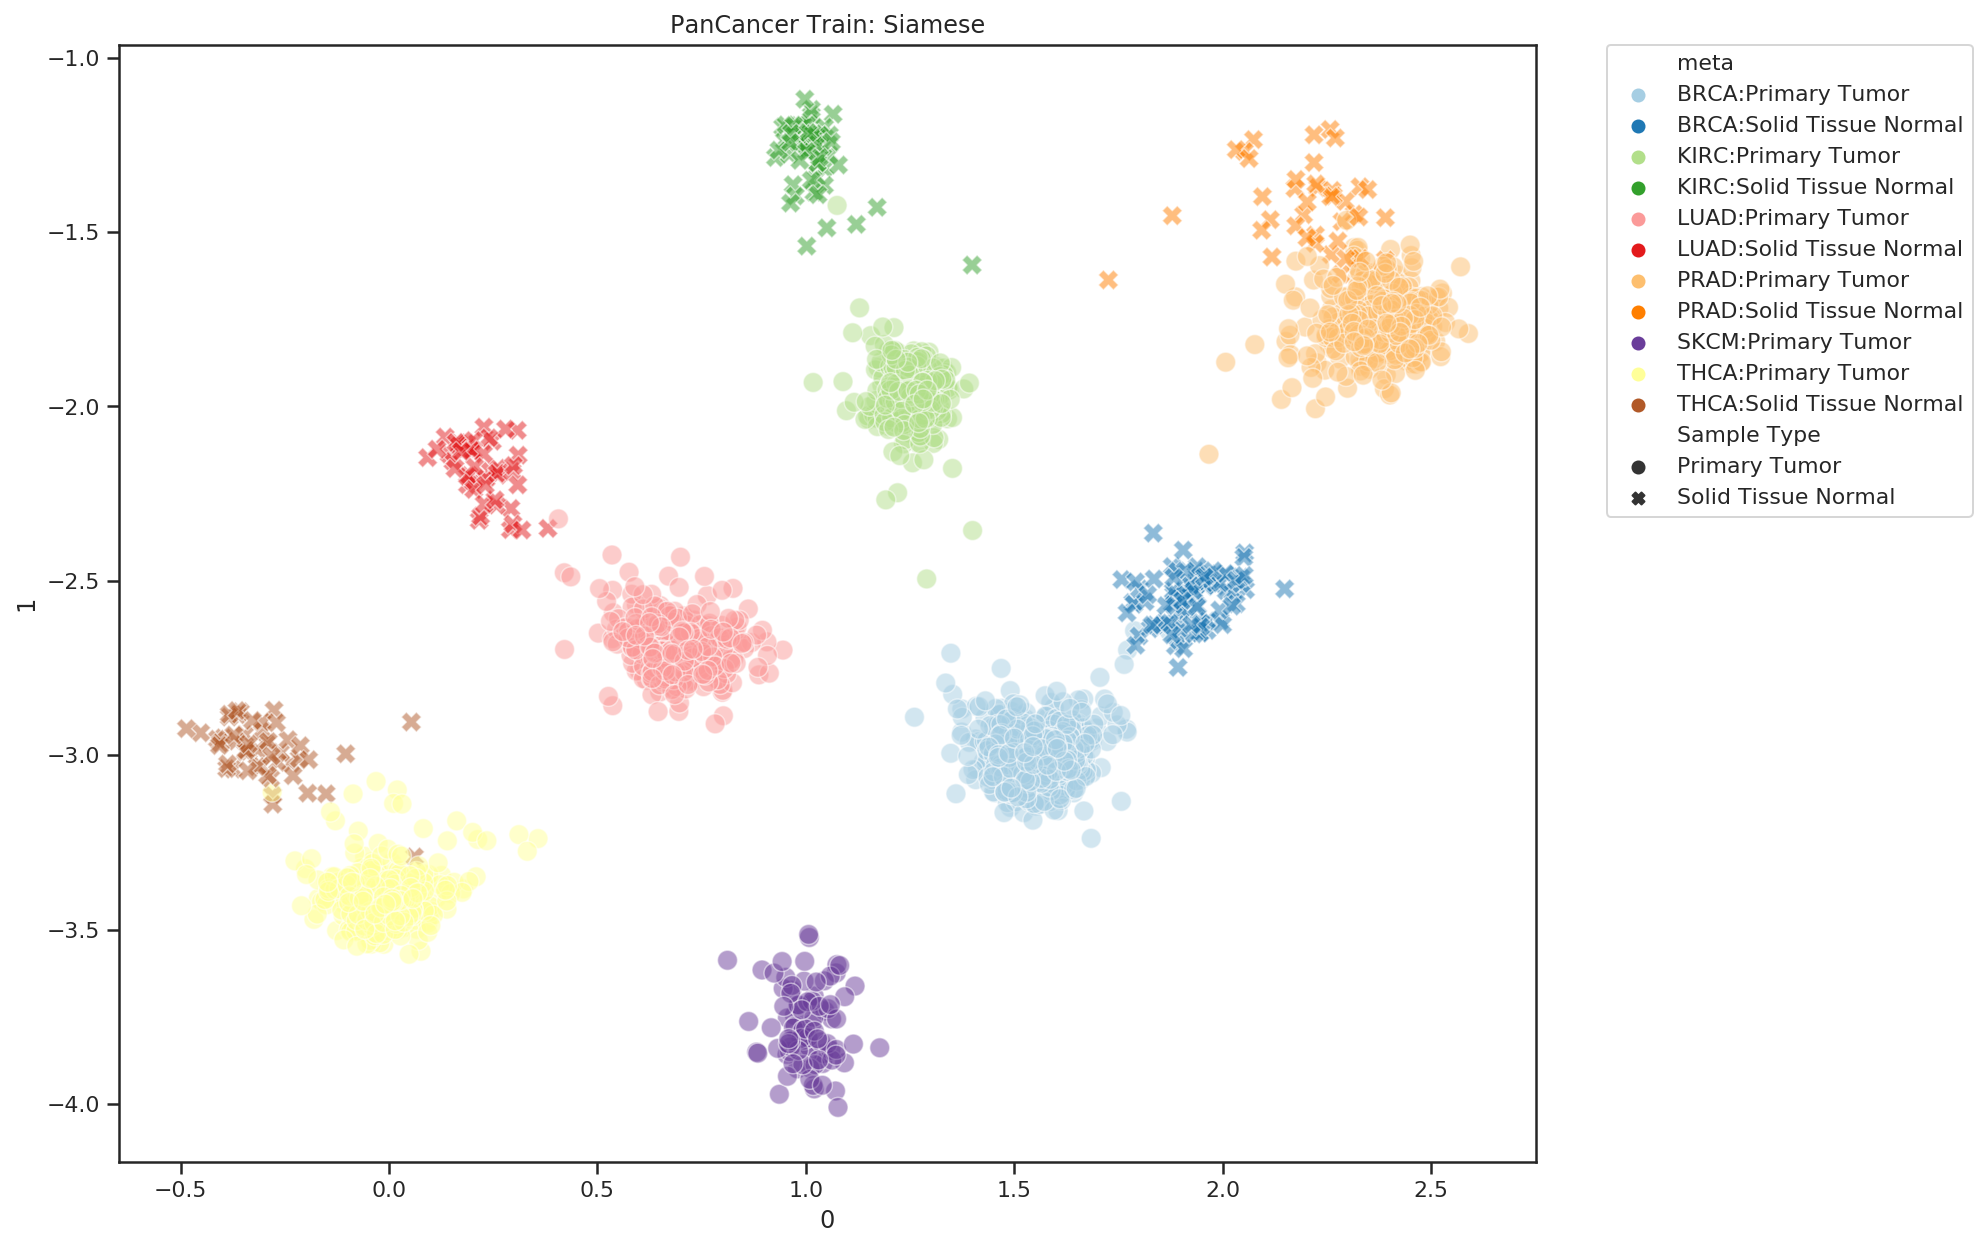

In [32]:
train_embeddings_cl, train_labels_cl = extract_embeddings(siamese_train_dataset.train_data, siamese_train_dataset.labels, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Train: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

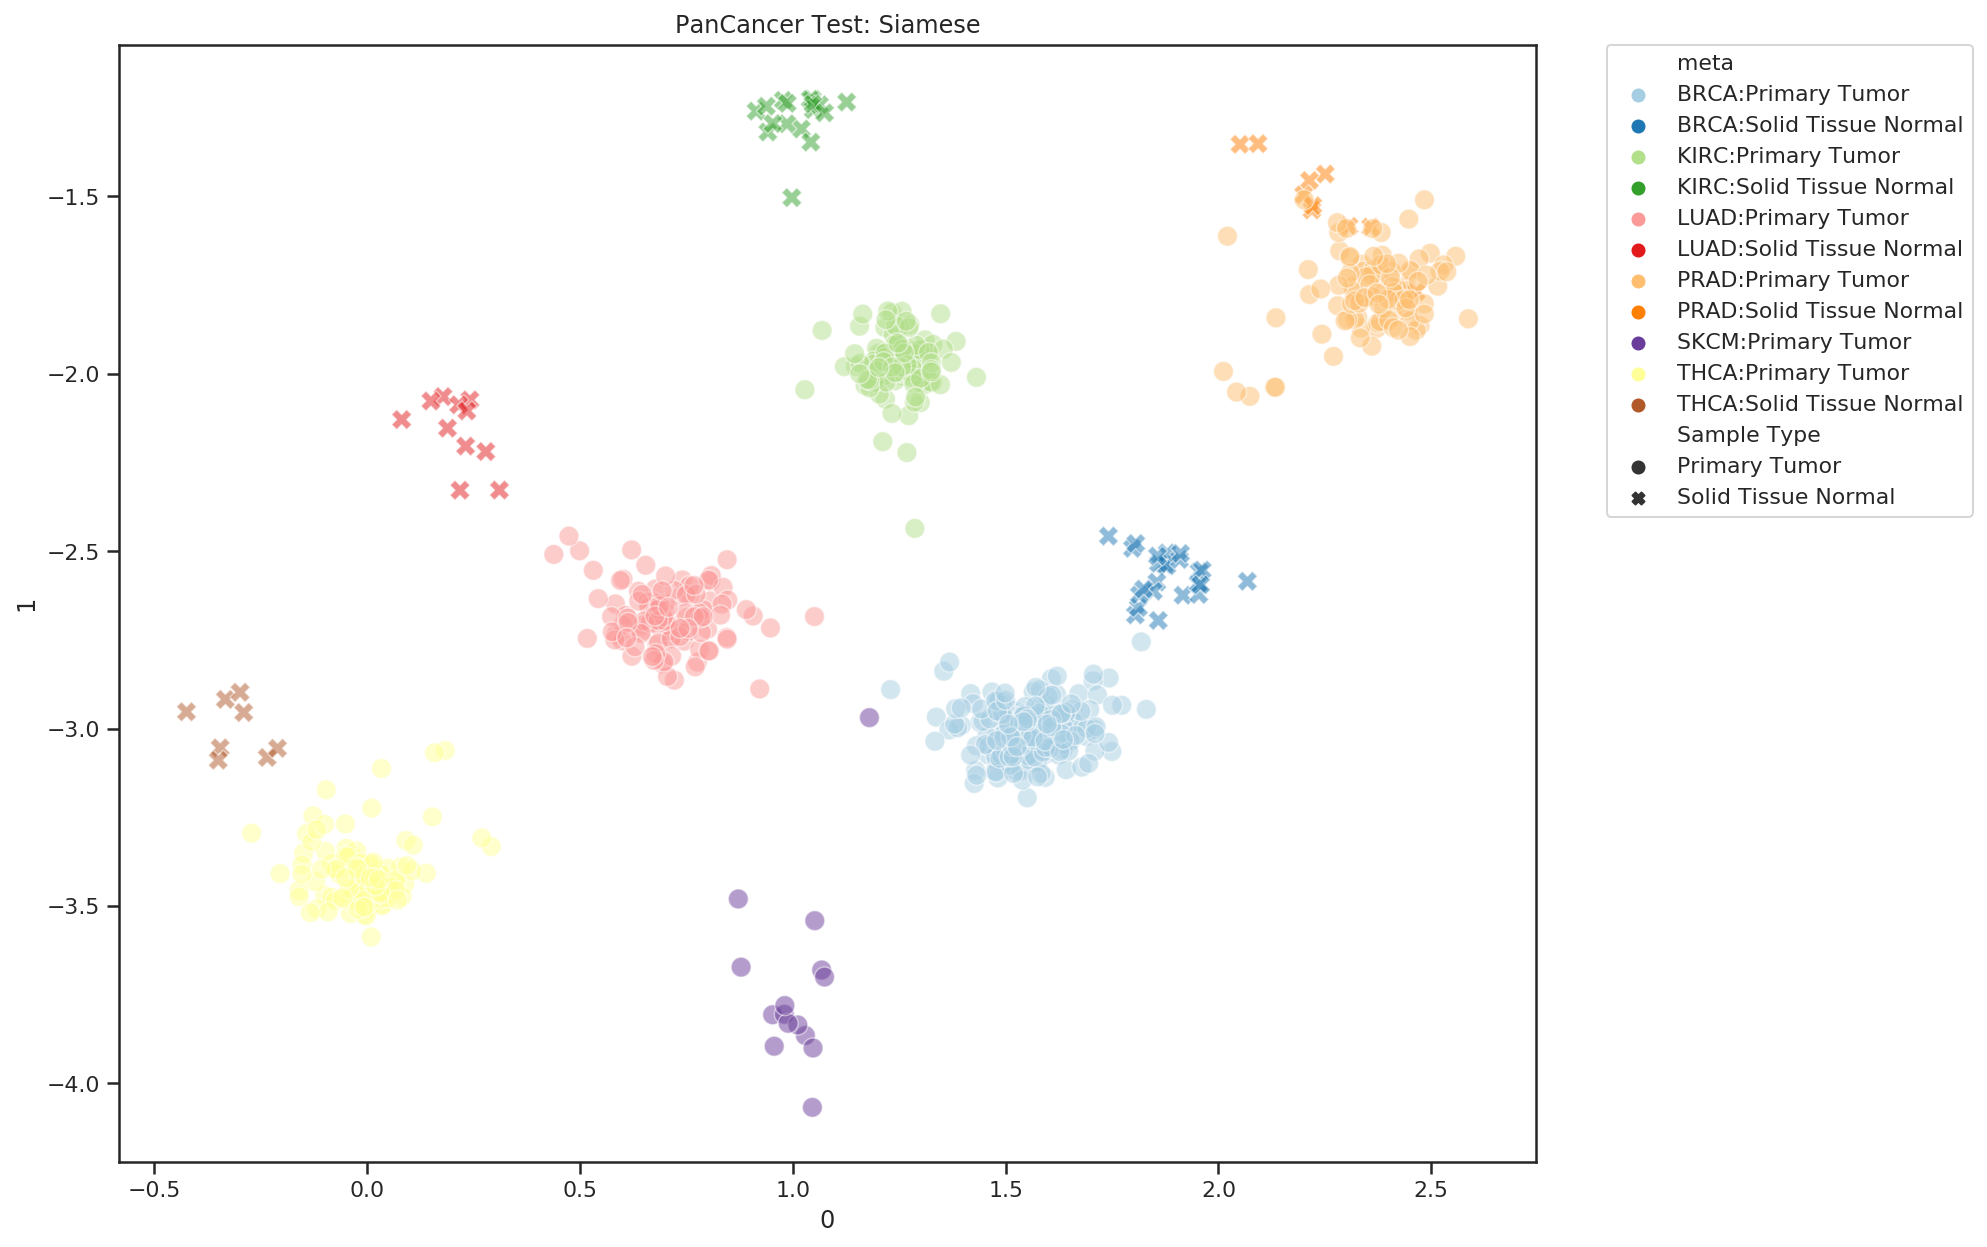

In [33]:
val_embeddings_baseline, val_labels_baseline = extract_embeddings(siamese_test_dataset.test_data, siamese_test_dataset.labels, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)